## Load datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import preprocess_input

In [2]:
train_image_dir = "data/DB/train"
test_image_dir = "data/DB/test"

#### Visualize images

In [3]:
nb_class = len(os.listdir(train_image_dir))
print(nb_class)

5


(227, 227, 3)


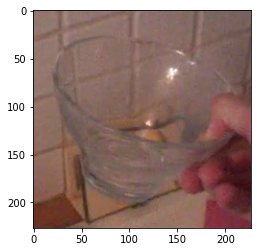

In [4]:
img = plt.imread(os.path.join(train_image_dir,'Bowl',os.listdir(train_image_dir+'/Bowl')[np.random.randint(600)]))
plt.imshow(img)

x_shape = img.shape
print(x_shape)

In [6]:
generator = ImageDataGenerator(preprocessing_function=preprocess_input)

## Build model

#### Hyperparameters

In [7]:
batch_size = 16
epochs = 20
learning_rate = 5e-5

#### VGG16 pre-train imagenet

In [8]:
from keras import models
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.optimizers import Adam

from numba import cuda 
device = cuda.get_current_device()
print(device)

<CUDA device 0 'b'NVIDIA GeForce GTX 1650 Ti''>


In [11]:
labels = os.listdir(train_image_dir)
print(labels)

['Bowl', 'CanOfCocaCola', 'MilkBottle', 'Rice', 'Sugar']


In [9]:
trainData = generator.flow_from_directory(train_image_dir, batch_size=batch_size, target_size=x_shape[:2])
testData = generator.flow_from_directory(test_image_dir, batch_size=batch_size, target_size=x_shape[:2], shuffle=False)

Found 4736 images belonging to 5 classes.
Found 3568 images belonging to 5 classes.


In [10]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=2)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=1e-6)

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=x_shape)

# Freezer les couches du VGG16
for layer in baseModel.layers[:15]:
	layer.trainable = False
	
x = baseModel.output
x = Flatten()(x) 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dense(nb_class, activation='softmax')(x)

modelvgg = models.Model(inputs=baseModel.input, outputs=x)
modelvgg.summary()

opt = Adam(learning_rate=learning_rate)
modelvgg.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Train model

In [11]:
history = modelvgg.fit(trainData, validation_data=testData, epochs=epochs, callbacks=[lr_reduce, earlyStopping])

Epoch 1/20
296/296 [==============================] - 317s 954ms/step - loss: 0.4177 - accuracy: 0.9189 - val_loss: 0.4745 - val_accuracy: 0.8927 - lr: 5.0000e-05
Epoch 2/20
296/296 [==============================] - 108s 365ms/step - loss: 0.0080 - accuracy: 0.9968 - val_loss: 0.4550 - val_accuracy: 0.9311 - lr: 5.0000e-05
Epoch 3/20
296/296 [==============================] - 85s 288ms/step - loss: 0.0251 - accuracy: 0.9939 - val_loss: 0.8343 - val_accuracy: 0.8941 - lr: 5.0000e-05
Epoch 4/20
296/296 [==============================] - 105s 356ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 0.4786 - val_accuracy: 0.9339 - lr: 5.0000e-05
Epoch 5/20
296/296 [==============================] - 94s 318ms/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 0.6731 - val_accuracy: 0.9297 - lr: 5.0000e-05
Epoch 6/20
296/296 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9964
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
296/296 [==

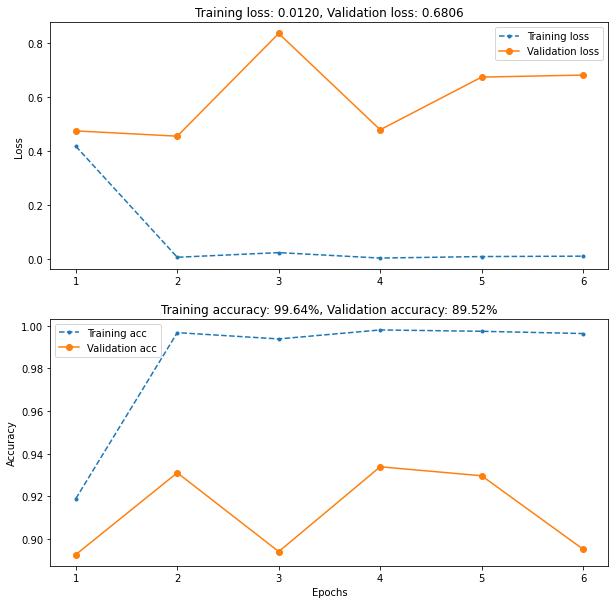

In [12]:
from utils.helpers import plot_loss_acc
plot_loss_acc(history)

In [13]:
modelvgg.save('models/vgg16_16_{epochs}_{acc}.h5'.format(epochs=epochs, acc=history.history['val_accuracy'][-1]))

## Test model

In [14]:
y_pred = modelvgg.predict(testData)

In [18]:
y_test = []

_, y_batch = testData.next()
i = 0

while i<len(testData):
    for y in y_batch:
        assert y.shape == (nb_class, )
        y_test.append(y)
    i+=1
    print("\r", len(y_test), end="")

    _, y_batch = testData.next()

y_test = np.array(y_test)

 3568

In [19]:
print(y_pred.shape, y_test.shape)

(3568, 5) (3568, 5)


In [20]:
def vect_argmax(vect):
    max = np.zeros_like(vect)
    max[np.argmax(vect)] = 1
    return max

In [21]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred=vect_argmax(y_pred), average="macro")

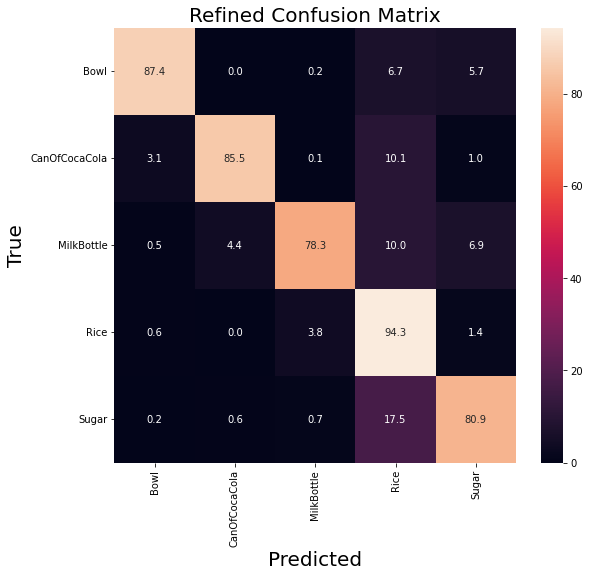

In [56]:
from utils.helpers import plot_multiclass_heatmap
plot_multiclass_heatmap(y_test, y_pred, labels, figsize=(9,8))

## Récupération de vidéo

In [5]:
import random as rd
import cv2, sys
import matplotlib.pyplot as plt
from keras import models
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from utils.helpers import plt_rectangle

In [6]:
video_dir = "data/VIDEOS"
boxes_dir = "data/GT"
train_image_dir = "data/DB/train"
test_image_dir = "data/DB/test"

labels = os.listdir(train_image_dir)
print(labels)

['Bowl', 'CanOfCocaCola', 'MilkBottle', 'Rice', 'Sugar']


In [7]:
classifier = models.load_model('models/vgg16_16_20_0.89.h5')

In [8]:
video_name = rd.choices(os.listdir(video_dir))[0]

aVideo = os.path.join(video_dir, video_name)
sample_name = video_name[:video_name.index('.')]
print(sample_name)
aBoxes = os.path.join(boxes_dir, f"{sample_name}_2_bboxes.txt")

label = video_name[:video_name.index('Place')]
label_id = os.listdir(train_image_dir).index(label)
print(label, label_id)

RicePlace3Subject3
Rice 3


In [9]:
pred_boxes = []

In [62]:
from skimage.transform import resize 

def extract_first_box(aBoxes):
        # extract the first box
        with open(aBoxes) as fp: 
            lines = fp.readlines()
            for line in lines: 
                elts = line.split()
                if len(elts) == 2:
                    assert(elts[1] == "0")
                else:
                    assert(len(elts) > 2)
                    assert(elts[1] == "1") #only one bbox per frame
                    x = (int)(elts[2])
                    y = (int)(elts[3])
                    w = (int)(elts[4])
                    h = (int)(elts[5])
                    return (int)(elts[0]) , (x, y, w, h)

def preprocess_img(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = resize(img_rgb, x_shape[:2])
    return preprocess_input(img_resize)

def generate_rdm_boxes_from_box(box, delta_dist,delta_taille, w_frame, h_frame) :
    x = box[0]
    y = box[1] 
    w = box[2]
    h = box[3]

    rdm_bboxes = []
    # générer des boites de même taille mais à des positions différentes
    for x_new in range(x-delta_dist, x+delta_dist,5) : 
        for y_new in range(y-delta_dist,y+delta_dist,5) : 
            if(x_new<=w_frame and y_new <=h_frame) : 
                for w_new in range(w-delta_taille, w+delta_taille,5) : 
                    for h_new in range(h-delta_taille, h+delta_taille,5) : 
                        w_new = min(w_new,w_frame-x_new)
                        h_new = min(h_new,h_frame-y_new)
                        if(w_new * h_new > 100 and w_new > 20 and h_new > 20): rdm_bboxes.append((x_new,y_new,w_new,h_new))
    return [rdm_bboxes[i] for i in np.random.choice(range(len(rdm_bboxes)), 32)]
    

In [63]:
first_frame, first_box = extract_first_box(aBoxes)
pred_boxes.append(first_box)

cap = cv2.VideoCapture(aVideo)
if (not cap.isOpened()):
    print("ERROR: unable to read video:", aVideo)
    sys.exit()

label_id = labels.index(label)
batch_size = 16

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break
    
    if i > first_frame:
        newBoxes = generate_rdm_boxes_from_box(pred_boxes[-1], 100, 10, *frame.shape[:2])
        proba = []
        j = 0
        while j < len(newBoxes):
            batch = []
            while len(batch) < batch_size and j < len(newBoxes):
                box = newBoxes[j]
                img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
                batch.append(preprocess_img(img))
                j += 1

            print(f'\rFrame: {i}', f'\t{j}/{len(newBoxes)}',' '*20, end="")
            batch = np.array(batch)
            model_prediction = classifier.predict(batch)
            proba.extend([pred[label_id] for pred in model_prediction])
        
        bestBox = newBoxes[np.argmax(proba)]
        pred_boxes.append(bestBox)
    
    i+=1
    # print('\rFrame: ',i,'\t\t\t\t\t')
    

Frame: 225 	32/32                     

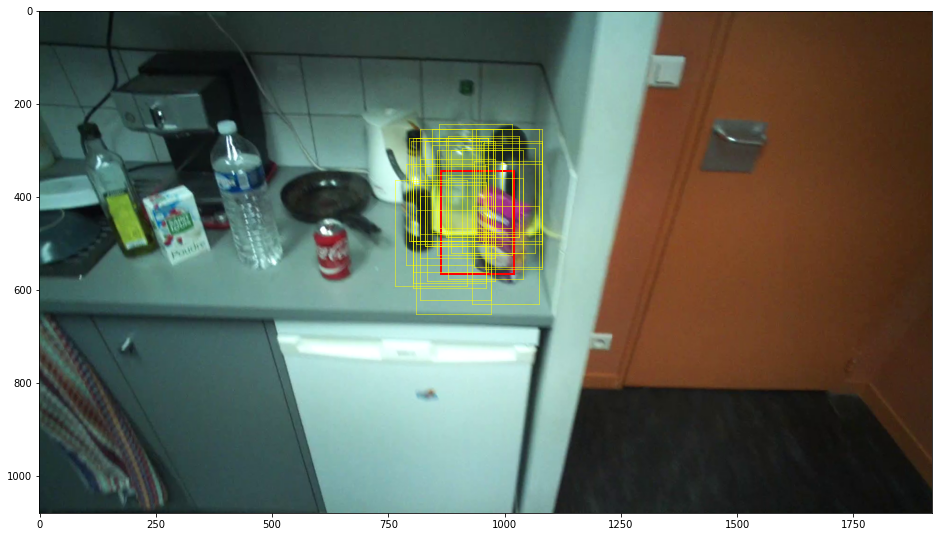

In [64]:
cap = cv2.VideoCapture(aVideo)
if (not cap.isOpened()):
    print("ERROR: unable to read video:", aVideo)
    sys.exit()

label_id = labels.index(label)
batch_size = 16

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break
    
    if i > first_frame+1:
        plt.figure(figsize=(16,16))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # r = pred_boxes[i-first_frame]
        newBoxes = generate_rdm_boxes_from_box(first_box, 100, 10, *frame.shape[:2])
        plt_rectangle(plt, *first_box[:2], first_box[0]+first_box[2], first_box[1]+first_box[3], color="red")
        for r in newBoxes:
            plt_rectangle(plt,*r[:2], r[0]+r[2], r[1]+r[3], linewidth=0.5)
        break
    i+=1


In [ ]:
cap = cv2.VideoCapture(aVideo)
if (not cap.isOpened()):
    print("ERROR: unable to read video:", aVideo)
    sys.exit()

label_id = labels.index(label)
batch_size = 16

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break
    
    if i > first_frame+1:
        plt.figure(figsize=(16,16))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # r = pred_boxes[i-first_frame]
        newBoxes = generate_rdm_boxes_from_box(first_box, 100, 10, *frame.shape[:2])
        plt_rectangle(plt, *first_box[:2], first_box[0]+first_box[2], first_box[1]+first_box[3], color="red")
        for r in newBoxes:
            plt_rectangle(plt,*r[:2], r[0]+r[2], r[1]+r[3], linewidth=0.5)
        break
    i+=1
